In [29]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [30]:
import sys, pathlib
sys.path.insert(0, str(pathlib.Path.cwd().parent))

In [31]:
from decoding.beliefPropagation import performBeliefPropagation
from decoding.OSD import performOSD

In [32]:
codes = [
    "[[72, 12, 6]]",
    "[[90, 8, 10]]",
    "[[108, 8, 10]]",
    "[[144, 12, 12]]",
    "[[288, 12, 18]]",
]

trials = 100
physicalErrorRates = np.logspace(-3.2, -1.3, 8)
results_BP = {}

In [33]:
np.random.seed(0)

In [34]:
for code in tqdm.tqdm(codes):
    oc = np.load(f'../codes/{code}.npz')
    name = code
    results_BP[name] = {}
    code = oc['Hx']
    Lx = oc['Lx']
    distance = oc['distance']
    n = len(code[0])
    logicalErrorRates = []
    BPs_fault_rates = []
    BPs_miscorrected_rates = []
    incorrectable_rates = []
    degeneracies = []
    
    for errorRate in physicalErrorRates:
        
        initialBeliefs = [np.log((1 - errorRate) / errorRate)] * n
        logical_error = 0
        BPs_fault = 0
        BPs_miscorrected = 0
        incorrectable = 0
        degenerateErrors = 0
        
        
        for _ in range(trials):
            
            #### CODE CAPACITY ERROR MODEL ####
            # non-trivial pythonic way to generate random bitstring with given error rate
            error = (np.random.random(n) < errorRate).astype(int)
            
            syndrome = (error @ code.T) % 2
            
            #### SIMPLE PHENOMENOLOGICAL ERROR MODEL ####
            # measurementError = (np.random.random(len(syndrome)) < errorRate).astype(int)
            # syndrome = (syndrome + measurementError) % 2
            
            detection, isSyndromeFound, llrs = performBeliefPropagation(code, syndrome, initialBeliefs, verbose=False)
            
            # if not isSyndromeFound:
                # logical_error += 1
                # BPs_fault += 1
                
                # detection = performOSD(code, syndrome, llrs, detection)
                
                

            # This is the XOR, between the actual error and the detected error. We are simulating the correction of the error
            residual = (detection + error) % 2
            
            syndromeLogic = (Lx @ residual) % 2
            
            if not np.any(syndromeLogic) and (np.array_equal(detection, error) == False):
                degenerateErrors += 1
            
            if np.any(syndromeLogic):
                logical_error += 1

                error_weight = np.sum(error)
                if error_weight < (distance // 2):
                    BPs_miscorrected += 1
                else:
                    incorrectable += 1
                                    
        
        ler = logical_error / trials
        logicalErrorRates.append(ler)
        BPs_fault_rates.append(BPs_fault)
        BPs_miscorrected_rates.append(BPs_miscorrected)
        incorrectable_rates.append(incorrectable)
        degeneracies.append(degenerateErrors)
        
    results_BP[name]['ler'] = logicalErrorRates
    results_BP[name]['BPs_fault'] = BPs_fault_rates
    results_BP[name]['BPs_miscorrected'] = BPs_miscorrected_rates
    results_BP[name]['incorrectable'] = incorrectable_rates
    results_BP[name]['degeneracies'] = degeneracies

100%|██████████| 5/5 [00:38<00:00,  7.70s/it]


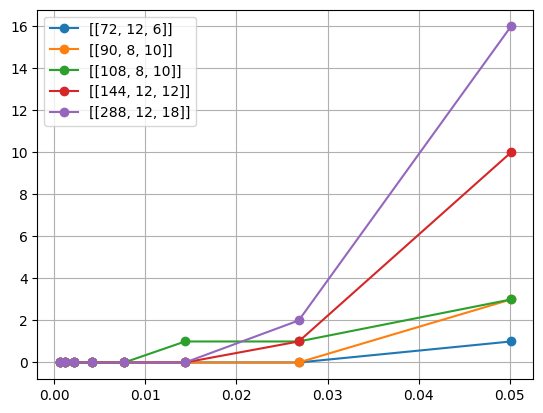

In [35]:
for name in results_BP:
    plt.plot(physicalErrorRates, results_BP[name]['degeneracies'], label=name, marker='o')
    plt.grid(True)
    plt.legend()
plt.show()

In [36]:
results_OSD = {}

for code in tqdm.tqdm(codes):
    oc = np.load(f'../codes/{code}.npz')
    name = code
    results_OSD[name] = {}
    code = oc['Hx']
    Lx = oc['Lx']
    distance = oc['distance']
    n = len(code[0])
    logicalErrorRates = []
    BPs_fault_rates = []
    BPs_miscorrected_rates = []
    incorrectable_rates = []
    degeneracies = []
    
    for errorRate in physicalErrorRates:
        
        initialBeliefs = [np.log((1 - errorRate) / errorRate)] * n
        logical_error = 0
        BPs_fault = 0
        BPs_miscorrected = 0
        incorrectable = 0
        degenerateErrors = 0
        
        
        for _ in range(trials):
            
            #### CODE CAPACITY ERROR MODEL ####
            # non-trivial pythonic way to generate random bitstring with given error rate
            error = (np.random.random(n) < errorRate).astype(int)
            
            syndrome = (error @ code.T) % 2
            
            #### SIMPLE PHENOMENOLOGICAL ERROR MODEL ####
            # measurementError = (np.random.random(len(syndrome)) < errorRate).astype(int)
            # syndrome = (syndrome + measurementError) % 2
            
            detection, isSyndromeFound, llrs = performBeliefPropagation(code, syndrome, initialBeliefs, verbose=False)
            
            if not isSyndromeFound:
                # logical_error += 1
                # BPs_fault += 1
                
                detection = performOSD(code, syndrome, llrs, detection)
                
                

            # This is the XOR, between the actual error and the detected error. We are simulating the correction of the error
            residual = (detection + error) % 2
            
            syndromeLogic = (Lx @ residual) % 2
            
            if not np.any(syndromeLogic) and (np.array_equal(detection, error) == False):
                degenerateErrors += 1
            
            if np.any(syndromeLogic):
                logical_error += 1

                error_weight = np.sum(error)
                if error_weight < (distance // 2):
                    BPs_miscorrected += 1
                else:
                    incorrectable += 1
                                    
        
        ler = logical_error / trials
        logicalErrorRates.append(ler)
        BPs_fault_rates.append(BPs_fault)
        BPs_miscorrected_rates.append(BPs_miscorrected)
        incorrectable_rates.append(incorrectable)
        degeneracies.append(degenerateErrors)
        
    results_OSD[name]['ler'] = logicalErrorRates
    results_OSD[name]['BPs_fault'] = BPs_fault_rates
    results_OSD[name]['BPs_miscorrected'] = BPs_miscorrected_rates
    results_OSD[name]['incorrectable'] = incorrectable_rates
    results_OSD[name]['degeneracies'] = degeneracies

100%|██████████| 5/5 [00:40<00:00,  8.01s/it]


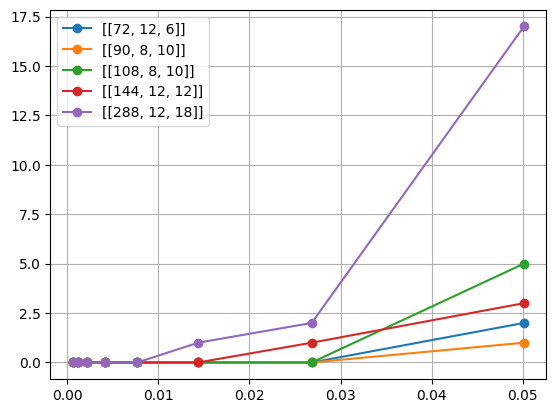

In [37]:
for name in results_OSD:
    plt.plot(physicalErrorRates, results_OSD[name]['degeneracies'], label=name, marker='o')
    plt.grid(True)
    plt.legend()
plt.show()

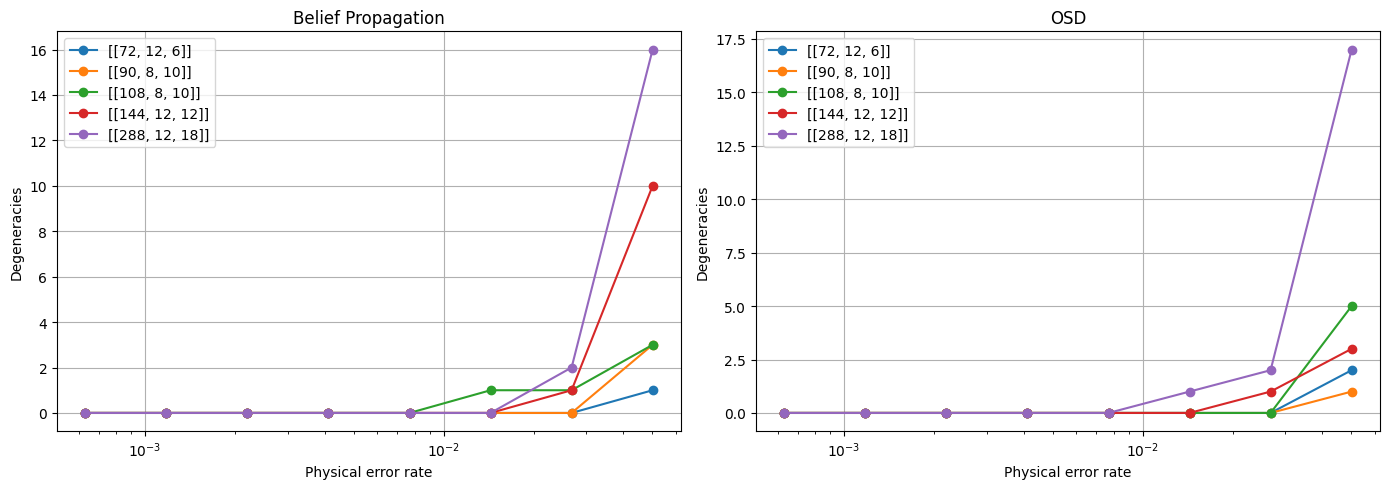

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: BP results
for name in results_BP:
    axes[0].plot(physicalErrorRates, results_BP[name]['degeneracies'], label=name, marker='o')
axes[0].grid(True)
axes[0].legend()
axes[0].set_xlabel('Physical error rate')
axes[0].set_xscale('log')
axes[0].set_ylabel('Degeneracies')
axes[0].set_title('Belief Propagation')

# Right plot: OSD results
for name in results_OSD:
    axes[1].plot(physicalErrorRates, results_OSD[name]['degeneracies'], label=name, marker='o')
axes[1].grid(True)
axes[1].legend()
axes[1].set_xlabel('Physical error rate')
axes[1].set_xscale('log')
axes[1].set_ylabel('Degeneracies')
axes[1].set_title('OSD')

plt.tight_layout()
plt.show()